In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from alpha_vantage.timeseries import TimeSeries
import os

In [2]:
TIME_SERIES = TimeSeries(key=os.environ.get("ALPHA_VANTAGE_KEY"), output_format="pandas", indexing_type="data")
COLUMN_RENAME_DAILY = {"date": "Date", "1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. adjusted close": "Adj Close", "6. volume": "Volume"}

In [3]:
TICKER = "CEI"
TICKER

'CEI'

In [4]:
dailyAdjustedRaw = TIME_SERIES.get_daily_adjusted(symbol=TICKER, outputsize="full")[0]
df = dailyAdjustedRaw.sort_values(by="date", ascending=False).reset_index().rename(columns=COLUMN_RENAME_DAILY).drop(["7. dividend amount", "8. split coefficient"], axis=1, inplace=False)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-04,3.31,3.65,3.05,3.09,3.09,212600954.0
1,2021-10-01,3.49,3.54,2.86,3.25,3.25,323930920.0
2,2021-09-30,4.13,4.37,3.44,3.82,3.82,460059396.0
3,2021-09-29,3.06,4.85,2.89,3.42,3.42,988353227.0
4,2021-09-28,2.88,3.44,2.62,3.22,3.22,761080418.0


In [5]:
df = df.head(120).sort_values(by="Date", ascending=True).reset_index().drop(["index"], axis=1, inplace=False)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-04-15,0.8200,0.8299,0.7320,0.7458,0.7458,2397151.0
1,2021-04-16,0.7400,0.7455,0.6754,0.7156,0.7156,2500707.0
2,2021-04-19,0.7200,0.7280,0.6675,0.6972,0.6972,1567921.0
3,2021-04-20,0.6827,0.6961,0.6524,0.6801,0.6801,1163124.0
4,2021-04-21,0.6930,0.7390,0.6702,0.7366,0.7366,2765518.0


In [6]:
# df = pd.read_csv('../dataset/GOOG-year.csv')
# df.head()

In [7]:
def buy_stock(
    real_movement,
    df,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'Date: %s day %d: total balances %f, not enough money to buy a unit price %f'
                % (df.Date[i], i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'Date: %s day %d: buy %d units at price %f, total balance %f'
                % (df.Date[i], i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('Date: %s day %d: cannot sell anything, inventory 0' % (df.Date[i], i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'Date: %s day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (df.Date[i], i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [8]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, df, initial_state = 1, 
                                                         delay = 4, initial_money = 1000, max_buy=1000, max_sell=1000)

Date: 2021-04-15 00:00:00 day 0: buy 1000 units at price 745.800000, total balance 254.200000
Date: 2021-05-07 00:00:00 day 16, sell 1000 units at price 655.100000, investment -12.161437 %, total balance 909.300000,
Date: 2021-05-20 00:00:00 day 25: buy 1000 units at price 617.400000, total balance 291.900000
Date: 2021-06-04 00:00:00 day 35, sell 1000 units at price 670.100000, investment 8.535795 %, total balance 962.000000,
Date: 2021-06-22 00:00:00 day 47: buy 1000 units at price 668.800000, total balance 293.200000
Date: 2021-07-12 00:00:00 day 60, sell 1000 units at price 594.500000, investment -11.109450 %, total balance 887.700000,
Date: 2021-07-22 00:00:00 day 68: buy 1000 units at price 488.500000, total balance 399.200000
Date: 2021-08-09 00:00:00 day 80, sell 1000 units at price 482.500000, investment -1.228250 %, total balance 881.700000,
Date: 2021-08-17 00:00:00 day 86: buy 1000 units at price 373.200000, total balance 508.500000
Date: 2021-08-25 00:00:00 day 92, sell 10

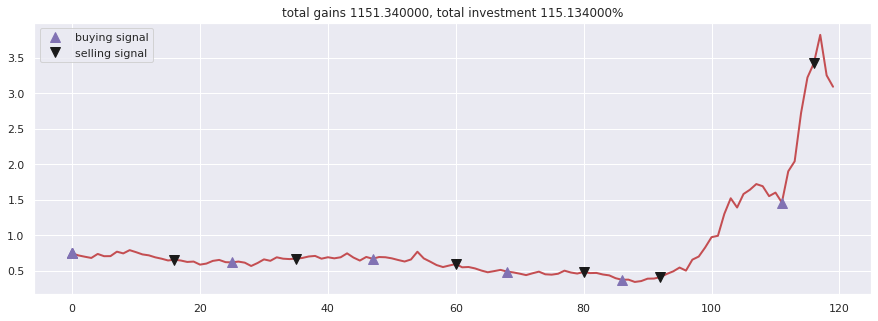

In [9]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()